In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split,learning_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils

### Chargement data mesures physiologiques

In [3]:
col = ['bpm','rmssd','bsv','sdnn','phase']
data_path = ("/home/fsz/Bureau/Developpement/test_classif/another_file.csv")
data = pd.read_csv(data_path ,names=col)
data.head()

,bpm,rmssd,bsv,sdnn,phase
0,86.022681,19.969923,1.808829,31.614496,stress
1,90.021803,17.691368,0.698733,17.222741,rest
2,104.030797,21.704360,1.338436,30.350783,stress
3,52.010452,79.913276,0.231673,54.306181,rest
4,104.014097,30.553062,1.535493,72.012498,stress


### Récupération des features et labels

In [4]:
X = data.iloc[:, 0:3].values
y = data.iloc[:,[4]].values

### Encodage des labels

In [5]:
lb = LabelBinarizer()
y = lb.fit_transform(y)
y=np.ravel(y,order='C')

### Représentation graphique du dataset

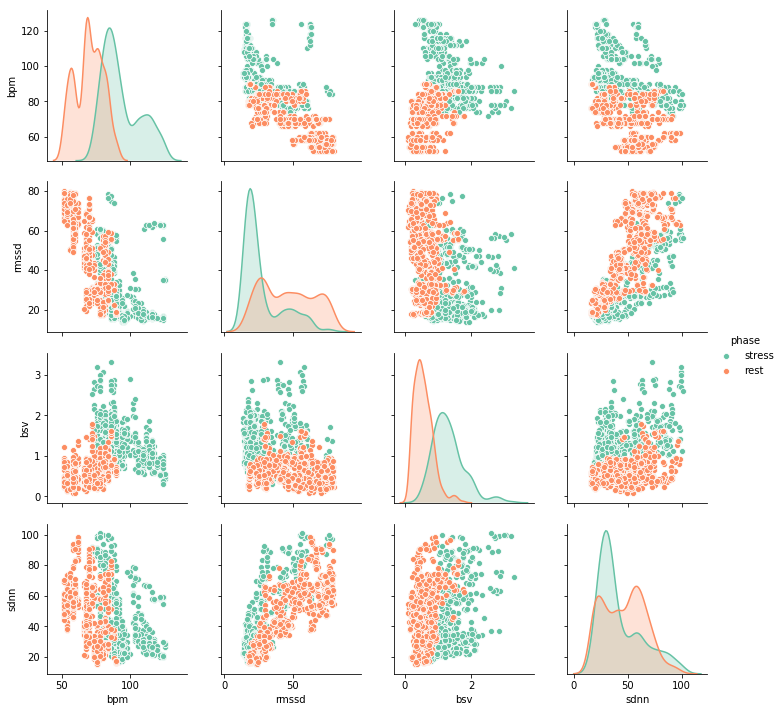

In [6]:
g = sns.pairplot(data=data,hue="phase",palette = "Set2")

### Matrice de corrélation des features

Text(0.5,1,'Corrélation des mesures de la variabilité cardiaque')

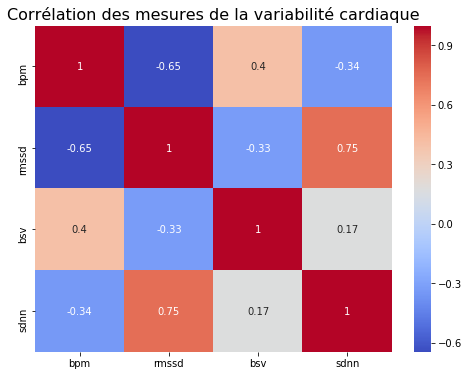

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))
corr = data.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Corrélation des mesures de la variabilité cardiaque', fontsize = '16')

### Séparation de la data : entraînement / test

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33)

### Optimisation des hyperparamètres via gridsearch pour la SVC

In [9]:
# Parametres a tester
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# Metriques a tester
scores = ['precision', 'recall']

for score in scores:
    print("# Optimisation des hyperparamètres pour %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Meilleurs paramètres:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) pour %r"
              % (mean, std * 2, params))
    print()

    print("Rapport de classification:")
    print()
    print("Le modèle est entraîné sur le jeu d'entraînement complet.")
    print("Les scores sont calculés sur le jeu d'évaluation complet.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Optimisation des hyperparamètres pour precision

Meilleurs paramètres:

{'gamma': 0.01, 'C': 100, 'kernel': 'rbf'}

Grid scores:

0.903 (+/-0.047) pour {'gamma': 0.01, 'C': 1, 'kernel': 'rbf'}
0.856 (+/-0.085) pour {'gamma': 0.001, 'C': 1, 'kernel': 'rbf'}
0.842 (+/-0.078) pour {'gamma': 0.0001, 'C': 1, 'kernel': 'rbf'}
0.953 (+/-0.044) pour {'gamma': 0.01, 'C': 10, 'kernel': 'rbf'}
0.918 (+/-0.068) pour {'gamma': 0.001, 'C': 10, 'kernel': 'rbf'}
0.857 (+/-0.095) pour {'gamma': 0.0001, 'C': 10, 'kernel': 'rbf'}
0.968 (+/-0.021) pour {'gamma': 0.01, 'C': 100, 'kernel': 'rbf'}
0.942 (+/-0.047) pour {'gamma': 0.001, 'C': 100, 'kernel': 'rbf'}
0.915 (+/-0.082) pour {'gamma': 0.0001, 'C': 100, 'kernel': 'rbf'}
0.966 (+/-0.022) pour {'gamma': 0.01, 'C': 1000, 'kernel': 'rbf'}
0.959 (+/-0.039) pour {'gamma': 0.001, 'C': 1000, 'kernel': 'rbf'}
0.931 (+/-0.050) pour {'gamma': 0.0001, 'C': 1000, 'kernel': 'rbf'}
0.936 (+/-0.043) pour {'C': 1, 'kernel': 'linear'}
0.937 (+/-0.041) pour {'C': 10,

### Fitting du modèle optimisé

In [10]:
svc = SVC(kernel='rbf', C=100,gamma=0.01).fit(X_train, y_train)

In [11]:
svc.score(X_test,y_test)

0.9808102345415778

### Courbe d'apprentissage

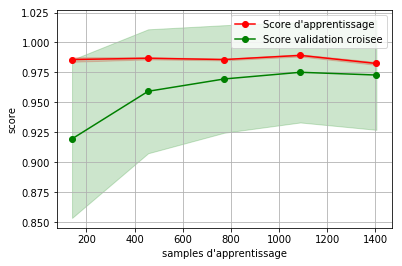

In [12]:
train_sizes, train_scores, test_scores = learning_curve(
        svc, X, y,cv=100)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Score d'apprentissage")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Score validation croisee")

plt.xlabel("samples d'apprentissage")
plt.ylabel("score")
plt.legend(loc="best")